# Modelo para predecir el IPC (Indice de percepción de la corrupción) en Colombia

El objetivo de este trabajo es predecir el IPC, el cual es es el ranking de corrupción más utilizado en el mundo. Su función es calificar los niveles percibidos de corrupción en el sector
público de cada país, de acuerdo con las opiniones de expertos y empresarios.La puntuación de un país es el nivel percibido de corrupción en el sector público, en una escala de 0 a 100, donde 0 significa altamente corrupto y 100 muy limpio o nada corrupto, esta puntuación es la variable que se busca predecir.

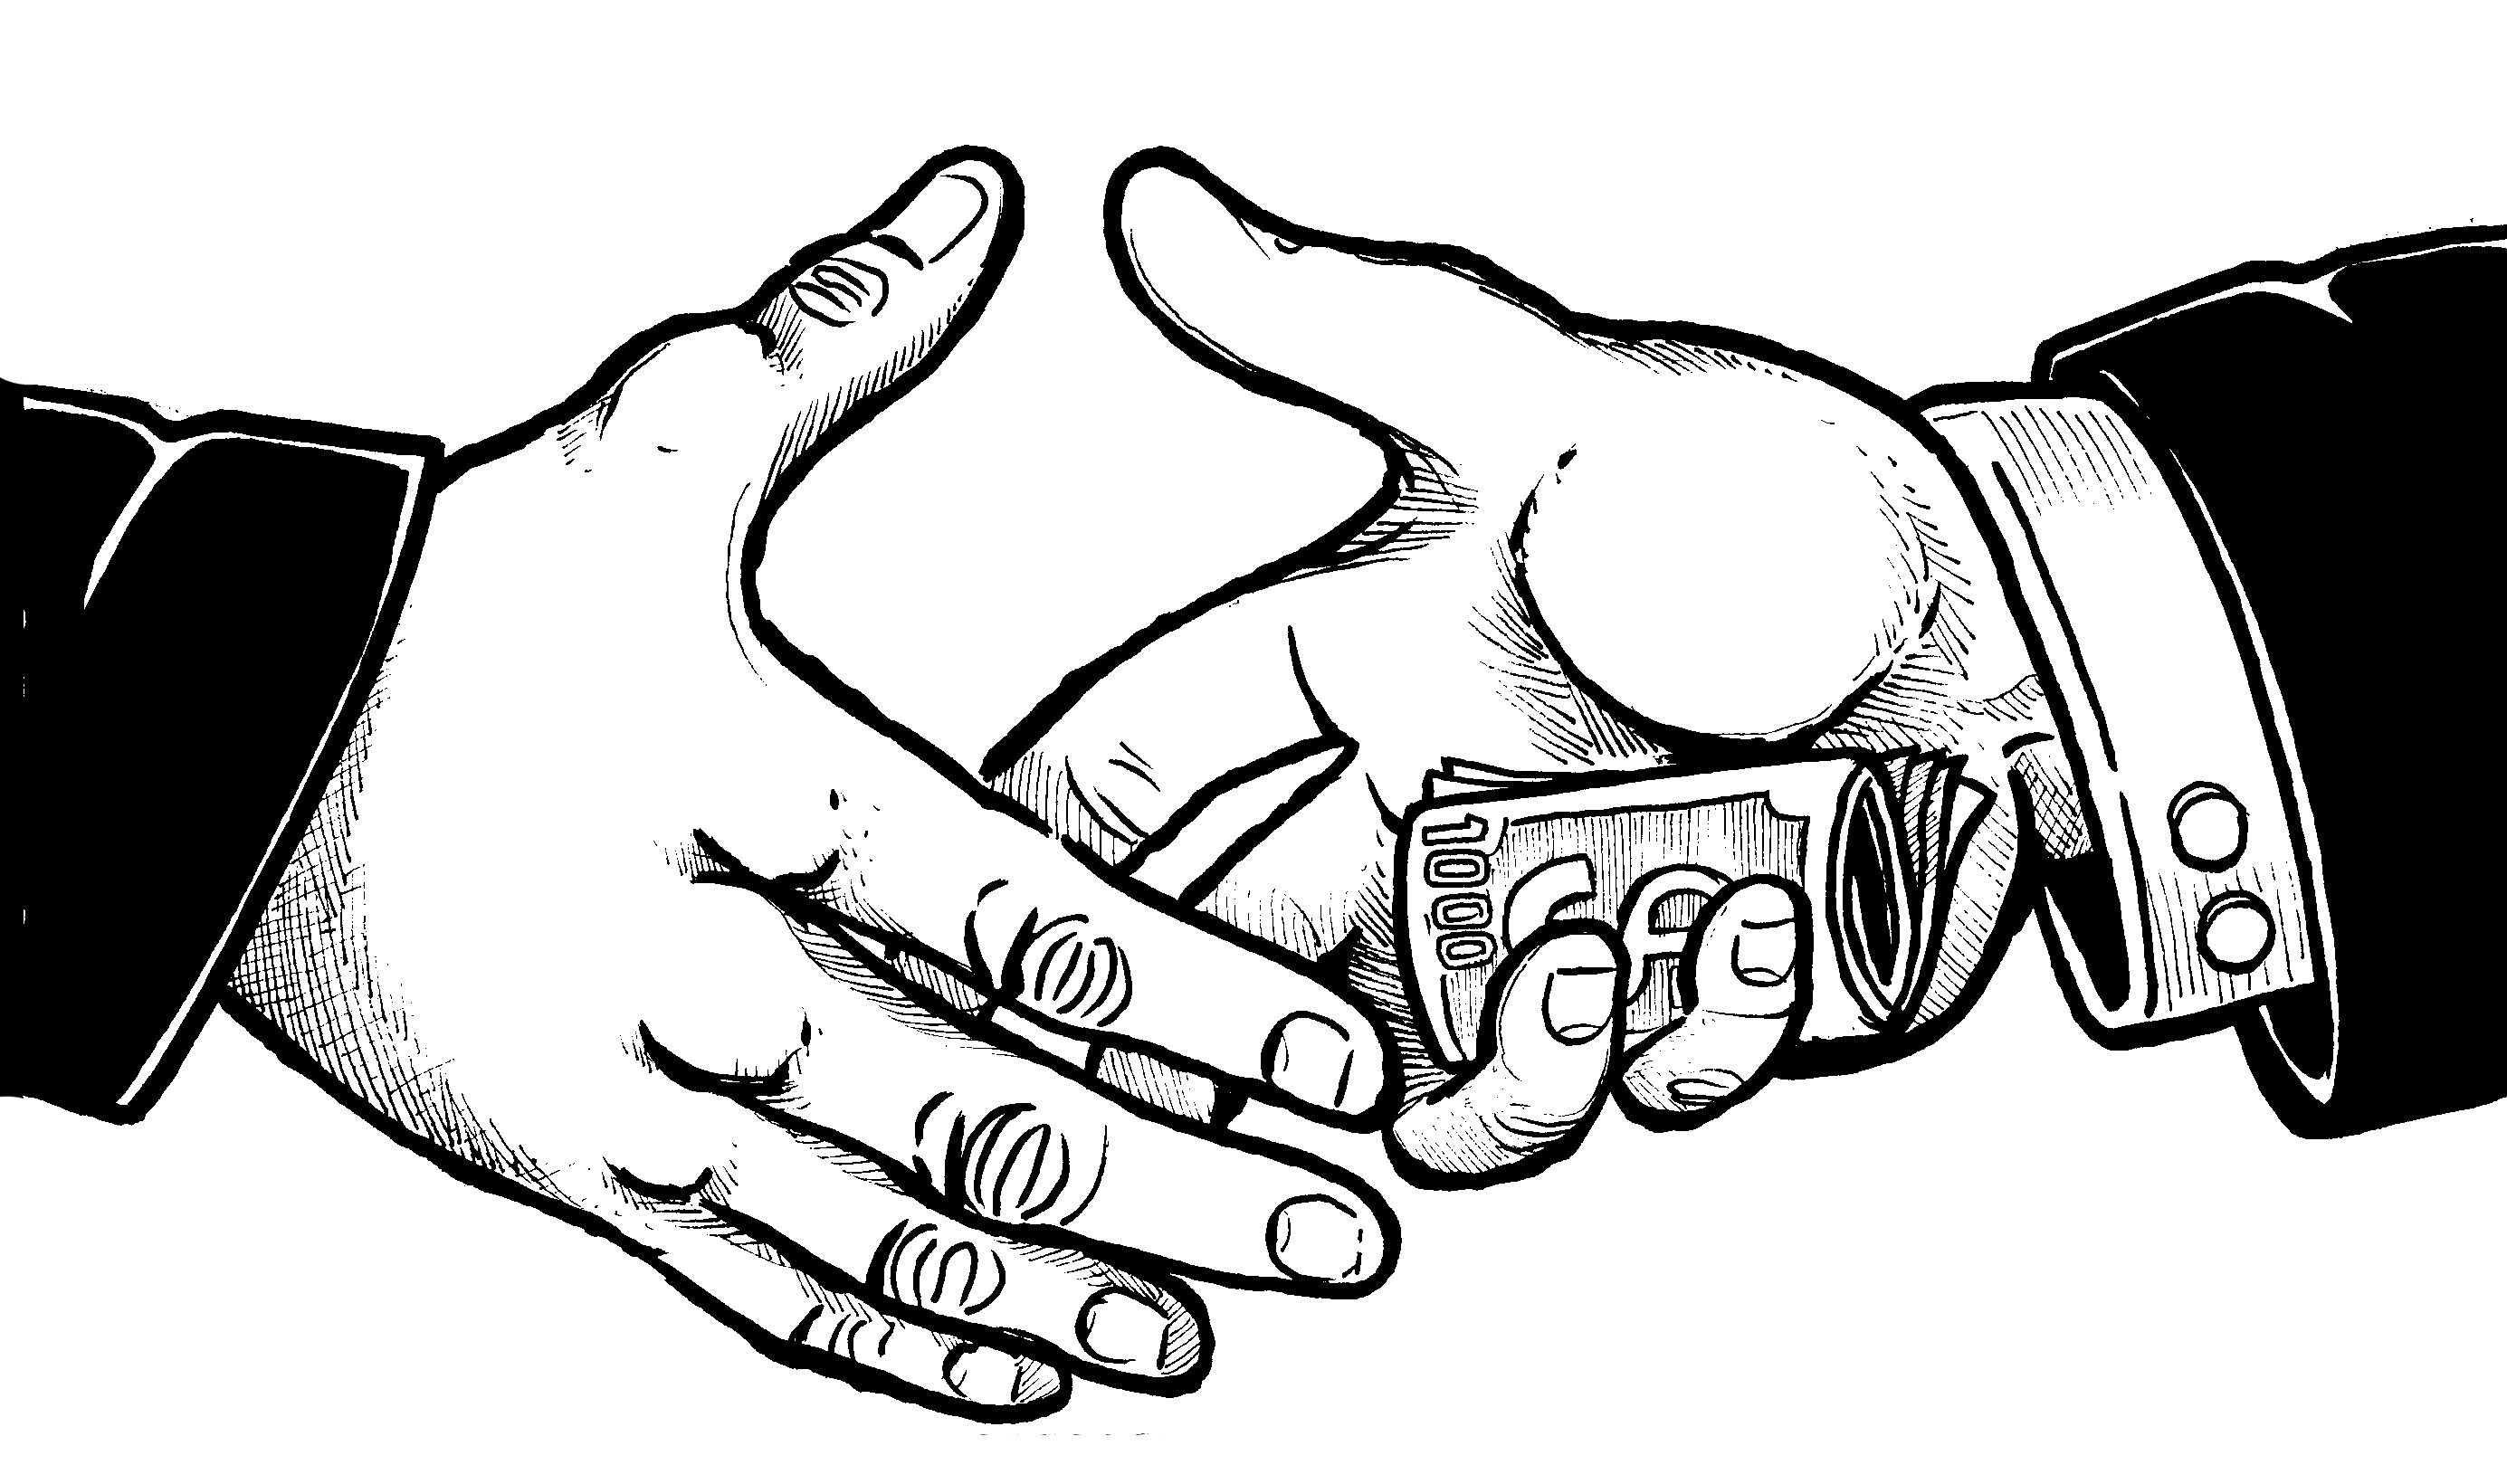

In [ ]:
#Librerias requeridas para el modelamiento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
import scipy.optimize as op
from math import log10
from logging import log


Los datos del IPC serán tomados de la siguiente [pagina web](https://datosmacro.expansion.com/estado/indice-percepcion-corrupcion/colombia)

In [ ]:
#Está función nos permite a partir de una URL extraer tablas en formato de DataFrame que pueda leer la librería Pandas.
web = pd.read_html('https://datosmacro.expansion.com/estado/indice-percepcion-corrupcion/colombia')
datos = web[0]

Demosle un vistazo a los datos, se puede visualizar que la variable que se buscaría modelar es la columna 'Índice de Corrupción'.Se tienen 27 datos, desde el año 1995 hasta el año 2021.

In [ ]:
datos.head()

,Fecha,Ranking de la Corrupción,Índice de Corrupción
0,2021,87º,39
1,2020,92º,39
2,2019,96º,37
3,2018,99º,36
4,2017,96º,37


In [ ]:
#Se realiza un poco de limpieza a los datos,como quitar algunos simbolos innecesarios y cambiar el tipo de variables para poder trabajar.
datos['Ranking de la Corrupción'] = datos['Ranking de la Corrupción'] .str.replace('º','')
datos['Ranking de la Corrupción'] = datos['Ranking de la Corrupción'].astype(int)
datos = datos.rename(columns={'Índice de Corrupción':'ipc'})

# Separamos nuestras variables.
tiempo = datos['Fecha'].values
ipc = datos['ipc'].values

# Exploración de los datos o EDA

In [ ]:
# Como ya se había mencionado, se cuenta con 27 registros.
datos.shape

(27, 3)

Se puede evidenciar que no hay datos nulos y todos son de tipo entero.

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Fecha                     27 non-null     int64
 1   Ranking de la Corrupción  27 non-null     int64
 2   ipc                       27 non-null     int64
dtypes: int64(3)
memory usage: 776.0 bytes


Miremos algunas estadisticas básicas acerca de los datos: Se puede ver que el IPC promedio en Colombia es de 34 aproximadamente, el IPC más bajo obtenido desde 1995 hasta 2021 fué de 22, un muy buen puntaje reflejando bajos niveles de corrupción y el IPC más alto registrado fué de 40.

In [ ]:
datos.describe()

,Fecha,Ranking de la Corrupción,ipc
count,27.000000,27.000000,27.000000
mean,2008.000000,72.962963,34.481481
std,7.937254,18.856710,4.862497
min,1995.000000,31.000000,22.000000
25%,2001.500000,59.000000,33.000000
50%,2008.000000,75.000000,36.000000
75%,2014.500000,91.000000,37.000000
max,2021.000000,99.000000,40.000000


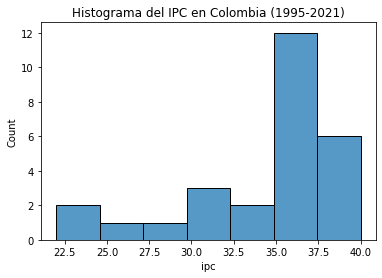

In [ ]:
sns.histplot(data = datos, x = "ipc")
plt.title('Histograma del IPC en Colombia (1995-2021)')
plt.show()

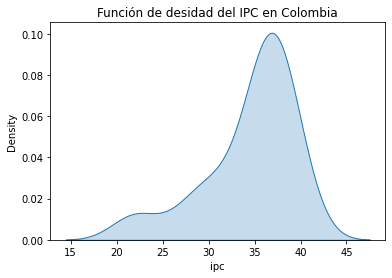

In [ ]:
sns.kdeplot(data = datos, x = 'ipc',shade='True')
plt.title('Función de desidad del IPC en Colombia')
plt.show()

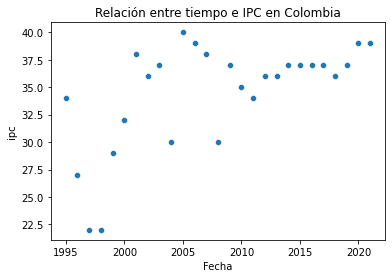

In [ ]:
sns.scatterplot(data = datos, x = 'Fecha', y = 'ipc')
plt.title('Relación entre tiempo e IPC en Colombia')
plt.show()

#Modelo Gompertz

Este modelo fué propuesto por Benjamin Gompertz originalmente diseñó la función para la Royal Society en 1825 para detallar su ley de mortalidad humana. La ley se basa en el supuesto a priori de que la resistencia de una persona a la muerte disminuye a medida que aumentan sus años.Decidí optar por este modelo pues pienso que la corrupción al igual que la mortalidad disminuye con los años, pues cada vez hay más educación acerca de las graves consecuencias de ser corrupto, en mi creencia y en lo aprendido de la catedra la corrupción tenderá a desaparecer.

La ecuación del modelo es la siguiente:

$$ V' = a\cdot V ⋅ ln(\frac{b}{V+c})$$

Dónde $a$ es una asíntota, $b$ y $c$ son números positivos.





In [ ]:
# Se define el modelo.
def modeloGP(ipc, t, par):
  a,b,c = par
  if b/ipc+c <= 0:
    dI = a*ipc*log10(-(b/ipc+c));
  else:
    dI = a*ipc*log10(b/ipc+c);
  return dI

Ahora definimos el residuo o el desajuste del modelo de acuerdo a los parametros $a,b,c$ usando mínimos cuadrados.

In [ ]:
#Función del residuo.
def residuoGP(par,ipc,tiempo):
  ipc_0 = 35
  ipcSimulado = odeint(modeloGP, ipc_0, tiempo, args=(par,))
  IS = ipcSimulado.transpose()
  res = ipc - IS;
  nres = np.linalg.norm(res)
  return nres

Por ejemplo si se utiliza $a=1,b=1,c=1$, se obtiene el siguiente desajuste:

In [ ]:
residuoGP([1, 1, 1],ipc,tiempo)

32.74139199971182

El objetivo ahora es encontrar unos parametros $a,b,c$ optimos que minimicen el desajuste del modelo, podemos entender el desajuste como un error que queremos hacerlo lo más bajo posible.Este es el modelo con los parametros $a=1,b=1,c=1$, podemos observar que nuestro modelo se ajusta muy mal a los datos.

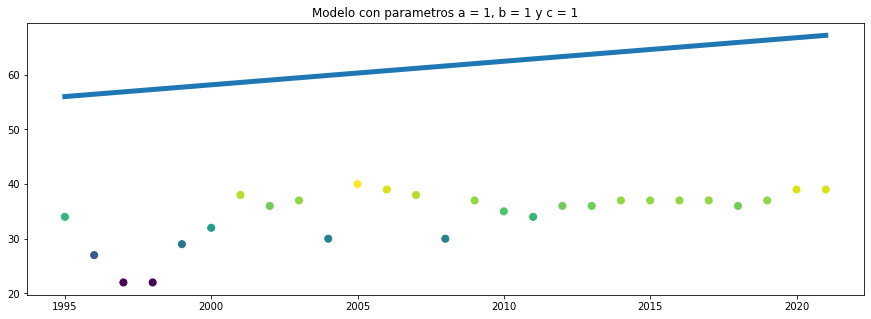

In [ ]:
tiempo_simulacion = np.linspace(1995, 2021, 1000)
ipc_0 = 56
ipcSimulado = odeint(modeloGP, ipc_0, tiempo_simulacion, args=([1, 1, 1],))
plt.figure(figsize=(15,5))
plt.scatter(tiempo, ipc, s = 50, c = ipc)
plt.plot(tiempo_simulacion,ipcSimulado,linewidth=5)
plt.title('Modelo con parametros a = 1, b = 1 y c = 1')
plt.show()

Como se dijo se intentará ajustar al modelo los mejores parametros posibles, si modificamos el parametro c que mide como crece nuestra fución, ponemos a=0.5 y b = 1, donde a mide el crecimiento intrinseco constante y b la capacidad de carga, que es el tamaño máximo que puede alcanzar una población o en nuestro caso el ipc máximo.También obtenemos un modelo que se ajusta muy mal a los datos.

In [ ]:
residuoGP([0.5,1,0.4],ipc,tiempo)

9868.261584007536

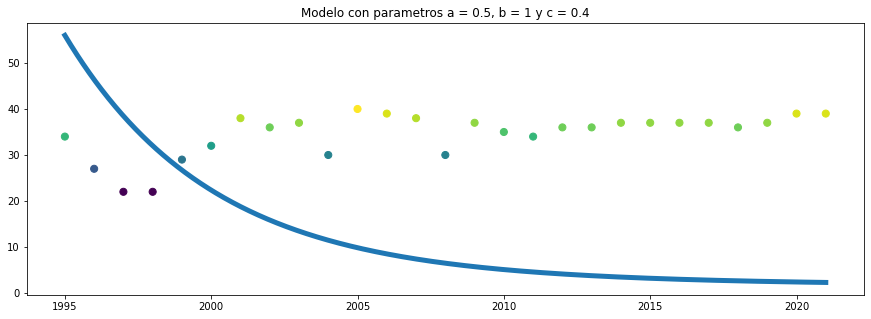

In [ ]:
tiempo_simulacion = np.linspace(1995, 2021, 1000)
ipc_0 = 56
ipcSimulado = odeint(modeloGP, ipc_0, tiempo_simulacion, args=([0.5,1,0.4],))
plt.figure(figsize=(15,5))
plt.scatter(tiempo, ipc, s = 50, c = ipc)
plt.plot(tiempo_simulacion,ipcSimulado,linewidth=5)
plt.title('Modelo con parametros a = 0.5, b = 1 y c = 0.4')
plt.show()

Ajustar estos parámetros de forma de manual no es muy eficiente ni eficaz, por lo tanto utilizaremos una funcionalidad de la librería de Scipy que nos permite optimizar estos parámetros mediante métodos númericos.

In [ ]:
optimo = op.minimize(residuoGP, [1,1,1], args = (ipc,tiempo),method='Powell')
parametro_optimo = optimo.x
print(optimo)

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.73184411e-03, -2.57164723e-05,  1.91335921e-06]])
     fun: 22.782113843298955
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([0.30333643, 1.01688461, 0.99927887])


Ya hemos optimizado los parámetros, el nuevo modelo tiene un desajuste de 22.78 (antes obtuvimos 32 y 9868) con parámetros a=0.30333643, b = 1.01688461 y c = 0.99927887, por lo tanto utilizaremos estos parámetros para nuestro modelo.

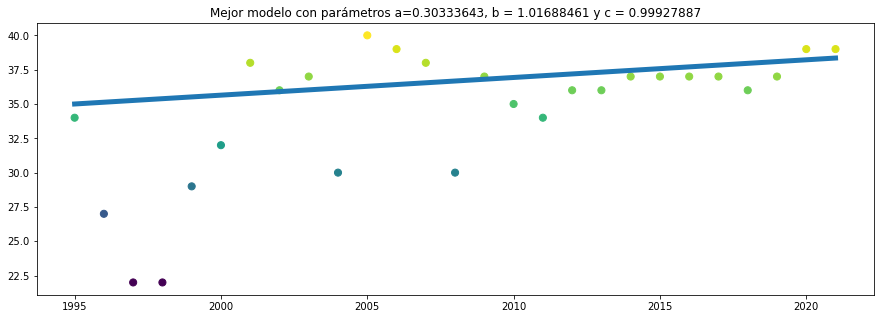

In [ ]:
tiempo_simulacion = np.linspace(1995, 2021, 1000)
ipc_0 = 35
ipcSimulado = odeint(modeloGP, ipc_0, tiempo_simulacion, args=(parametro_optimo,))
plt.figure(figsize=(15,5))
plt.scatter(tiempo, ipc, s = 50, c = ipc)
plt.plot(tiempo_simulacion,ipcSimulado,linewidth=5)
plt.title('Mejor modelo con parámetros a=0.30333643, b = 1.01688461 y c = 0.99927887')
plt.show()

Finalmente, a pesar de los pocos datos que tenemos encontramos un modelo que se ajusta considerablemente bien a los datos, según nuestro modelo el IPC seguirá aumentando lo cual rechaza mi hipótesis queda descartada según este modelo, también podemos ver que generaliza bien y sigue la tendencia de los datos.